# JuliaR

### On the GLM package and similarities with R

https://github.com/angus-lewis/JuliaR

run the code from `getPackages.jl` before starting.

---

---

---

---

---

## Load our packages

 + Plots.jl for plotting
 + GLM.jl the linear models package
 + IterTools.jl you may not *need* this, but it's here because it clashes with DataFrames.jl
 + DataFrames.jl for dataframes type and manipulation 
 + RDatasets.jl most of the datasets from R packages 

In [1]:
# some other packages we need 
using Plots, GLM, IterTools, DataFrames
import RDatasets

note there is a clash between `IterTools.groupby` and `DataFrames.groupby`. 

Julia will throw an error it we try to call groupby

In [2]:
groupby(1)

LoadError: [91mUndefVarError: groupby not defined[39m

We must qualify with dot syntax. i.e. for the DataFrames version,  

In [3]:
DataFrames.groupby(DataFrame(a = [1;2], b = [3;4]),:b)

,a,b
,Int64,Int64
1,1,3
,a,b
,Int64,Int64
1,2,4


---

---

---

---

---

## Loading data 

In [4]:
cars = RDatasets.dataset("Mass", "Cars93")
first(cars,5)

,Manufacturer,Model,Type,MinPrice,Price,MaxPrice,MPGCity,MPGHighway
,Cat…,String,Cat…,Float64,Float64,Float64,Int32,Int32
1,Acura,Integra,Small,12.9,15.9,18.8,25,31
2,Acura,Legend,Midsize,29.2,33.9,38.7,18,25
3,Audi,90,Compact,25.9,29.1,32.3,20,26
4,Audi,100,Midsize,30.8,37.7,44.6,19,26
5,BMW,535i,Midsize,23.7,30.0,36.2,22,30


#### TASK: Load the cars dataset 

---

---

---

---

---

## Linear Models 

Try to follow along, i.e. run the same code as I go. This notebook is on GitHub if you want to a copy. 

In [5]:
notRotary(cyl) = !isequal(cyl,"rotary") # exclude rotary engines
filter!(:Cylinders => notRotary, cars)
first(cars[:,[:Cylinders]],5)

,Cylinders
,Cat…
1,4
2,6
3,6
4,6
5,4


**Task: filter out the rotary engines**

----
Fitting linear models with the GLM package in Julia is much like R (this is deliberate).

In [6]:
lm1 = lm(@formula(MPGCity ~ Cylinders), cars)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.CholeskyPivoted{Float64,Array{Float64,2}}}},Array{Float64,2}}

MPGCity ~ 1 + Cylinders

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)    39.3333     1.95222   20.15    <1e-33    35.4531    43.2136
Cylinders: 4  -14.4762     2.0111    -7.20    <1e-9    -18.4735   -10.4789
Cylinders: 5  -20.8333     3.08673   -6.75    <1e-8    -26.9685   -14.6981
Cylinders: 6  -20.914      2.0445   -10.23    <1e-15   -24.9776   -16.8503
Cylinders: 8  -22.3333     2.33335   -9.57    <1e-14   -26.9711   -17.6955
──────────────────────────────────────────────────────────────────────────

Let's explore the `lm` function a little. 

Julia determines whether a variable is continous or categorical automatically based on the *type* of the data.

To code Cylinders as a countinuous variable we transform to a `Float64` (at least this is the only way I could work it out). 

In [7]:
transform!(cars, :Cylinders => (x->parse.(Float64,string.(x))) => :Cylinders);

In [8]:
cars[:,[:Cylinders]] |> x -> first(x,5) 

,Cylinders
,Float64
1,4.0
2,6.0
3,6.0
4,6.0
5,4.0


Now it's a Float64 and therefore continous (in the eyes of GLM)

In [9]:
lm2 = lm(@formula(MPGCity ~ Cylinders), cars)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.CholeskyPivoted{Float64,Array{Float64,2}}}},Array{Float64,2}}

MPGCity ~ 1 + Cylinders

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  37.1344     1.69413   21.92    <1e-37   33.7687    40.5001
Cylinders    -2.96141    0.329977  -8.97    <1e-13   -3.61696   -2.30585
────────────────────────────────────────────────────────────────────────

To go back to (or to change the way that) categorical variables are used by GLM you set the *contrasts*. i.e.

In [10]:
lm3 = lm(@formula(MPGCity ~ Cylinders), cars, contrasts = Dict(:Cylinders => DummyCoding()))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.CholeskyPivoted{Float64,Array{Float64,2}}}},Array{Float64,2}}

MPGCity ~ 1 + Cylinders

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)      39.3333     1.95222   20.15    <1e-33    35.4531    43.2136
Cylinders: 4.0  -14.4762     2.0111    -7.20    <1e-9    -18.4735   -10.4789
Cylinders: 5.0  -20.8333     3.08673   -6.75    <1e-8    -26.9685   -14.6981
Cylinders: 6.0  -20.914      2.0445   -10.23    <1e-15   -24.9776   -16.8503
Cylinders: 8.0  -22.3333     2.33335   -9.57    <1e-14   -26.9711   -17.6955
────────────────────────────────────────────────────────────────────────────

The table output from `lm` can be a bit of a pain. 

The output of `lm` is a `StatsModels.TableRegressionModel` which contains 
 + model (:model) info about the response (:rr) and predictor (:pp)
 + the model frame (:mf)
 + model matrix (:mm)

In [11]:
lm1

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.CholeskyPivoted{Float64,Array{Float64,2}}}},Array{Float64,2}}

MPGCity ~ 1 + Cylinders

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)    39.3333     1.95222   20.15    <1e-33    35.4531    43.2136
Cylinders: 4  -14.4762     2.0111    -7.20    <1e-9    -18.4735   -10.4789
Cylinders: 5  -20.8333     3.08673   -6.75    <1e-8    -26.9685   -14.6981
Cylinders: 6  -20.914      2.0445   -10.23    <1e-15   -24.9776   -16.8503
Cylinders: 8  -22.3333     2.33335   -9.57    <1e-14   -26.9711   -17.6955
──────────────────────────────────────────────────────────────────────────

In [12]:
fieldnames(StatsModels.TableRegressionModel)

(:model, :mf, :mm)

In [13]:
fieldnames(LinearModel)

(:rr, :pp)

In [14]:
lm1.model.pp

GLM.DensePredChol{Float64,LinearAlgebra.CholeskyPivoted{Float64,Array{Float64,2}}}([1.0 1.0 … 0.0 0.0; 1.0 0.0 … 1.0 0.0; … ; 1.0 1.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.0], [39.33333333333342, -14.47619047619056, -20.833333333333414, -20.913978494623738, -22.333333333333417], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], LinearAlgebra.CholeskyPivoted{Float64,Array{Float64,2}}([9.591663046625438 5.108603144398332 … 0.7298004491997617 0.20851441405707477; 49.0 4.785621580635422 … -0.7790546759173944 -0.22258705026211267; … ; 31.0 0.0 … 1.707825127659933 -0.6831300510639732; 7.0 0.0 … 0.0 1.0954451150103324], 'U', [1, 2, 4, 5, 3], 5, -1.0, 0), [6.94817396187755e-310 6.94816570035925e-310 … 2.121995787e-314 2.217286315e-314; 0.0 6.94816570035925e-310 … 0.0 6.94816604253647e-310; … ; 0.0 0.0 … 3.7059444e-317 1.0e-323; NaN 0.0 … 1.6578092e-316 2.483328115342884e-307], [NaN 1.0e-323 … 3.0e-323 5.0e-323; 5.0e-324 1.5e-323 … 4.0e-323 3.0e-323; … ; 5.0e-324 2.0e-323 … 3.0e-323 2.5e-323; 1.0e-323

In [15]:
fieldnames(GLM.DensePredChol)

(:X, :beta0, :delbeta, :scratchbeta, :chol, :scratchm1, :scratchm2)

In [16]:
lm1.model.pp.beta0

5-element Array{Float64,1}:
  39.33333333333342
 -14.47619047619056
 -20.833333333333414
 -20.913978494623738
 -22.333333333333417

Yuck!!

All the useful stuff is usually in the coeftable anyway. 

You might prefer it as a DataFrame

In [17]:
lm1Coeffs = DataFrame(coeftable(lm1))

,Name,Coef.,Std. Error,t,Pr(>|t|),Lower 95%,Upper 95%
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,(Intercept),39.3333,1.95222,20.148,1.60159e-34,35.4531,43.2136
2,Cylinders: 4,-14.4762,2.0111,-7.19816,2.04355e-10,-18.4735,-10.4789
3,Cylinders: 5,-20.8333,3.08673,-6.74931,1.58161e-9,-26.9685,-14.6981
4,Cylinders: 6,-20.914,2.0445,-10.2294,1.37814e-16,-24.9776,-16.8503
5,Cylinders: 8,-22.3333,2.33335,-9.57136,3.03731e-15,-26.9711,-17.6955


---

Is it linear?

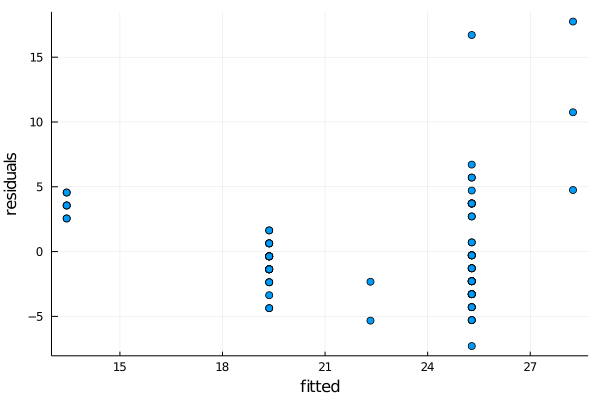

In [18]:
scatter(
    predict(lm2), residuals(lm2),
    xlabel = "fitted", ylabel = "residuals",
    legend = false,
)

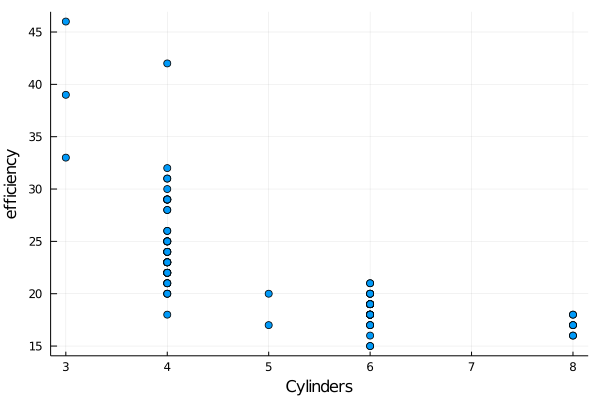

In [19]:
scatter(
    cars[:,:Cylinders],cars[:,:MPGCity],
    xlabel = "Cylinders", ylabel = "efficiency",
    legend = false,
)

---

## Tasks

With the cars data set 
 - exclude rotary cylinder engines
 - convert :Cylinders to a continuous predictor
 - with city efficiency as the response variable, fit a model with all the predictors
 - with city efficiency as the response variable, implement an exhastive algorithm to find the linear model which fits best with the following predictors
 
 [:Weight,
 
 :Price,
 
 :Length,
 
 :FuelTankCapacity,
 
 :Wheelbase,
 
 :RPM,
 
 :Horsepower, 
 
 :EngineSize, 
 
 :Cylinders, 
 
 :City, 
 
 :Passengers]

Tips: 
 - functions in the someFunctions.jl might be useful
 - the function `parse.(Int,"1")` converts the string `"1"` to an `Int` 
 - the function `deviance(aLinerModel)` extracts the deviance for the linear model `aLinearModel`
 - the `IterTools` package has a `subsets` function which enumeartes all subsets of a vector
 - I found it easier to specify the model matrix rather than pass an `@formula` object to `lm`

In [20]:
#Pkg.add("IterTools")
#using IterTools
cars = RDatasets.dataset("Mass", "Cars93")
vars = propertynames(cars[!,Not(:MPGCity)])
varsPowerSet = subsets(vars)

IterTools.Subsets{Array{Symbol,1}}([:Manufacturer, :Model, :Type, :MinPrice, :Price, :MaxPrice, :MPGHighway, :AirBags, :DriveTrain, :Cylinders  …  :Passengers, :Length, :Wheelbase, :Width, :TurnCircle, :RearSeatRoom, :LuggageRoom, :Weight, :Origin, :Make])

In [21]:
filterFun(cyl) = !isequal(cyl,"rotary") # exclude rotary engines
filter!(:Cylinders => filterFun, cars)  
transform!(cars, :Cylinders => (x->parse.(Float64,string.(x))) => :Cylinders) |> x -> first(x,5) 
# transform!(cars, :MPGCity => convertMPG => :MPGCity)

,Manufacturer,Model,Type,MinPrice,Price,MaxPrice,MPGCity,MPGHighway
,Cat…,String,Cat…,Float64,Float64,Float64,Int32,Int32
1,Acura,Integra,Small,12.9,15.9,18.8,25,31
2,Acura,Legend,Midsize,29.2,33.9,38.7,18,25
3,Audi,90,Compact,25.9,29.1,32.3,20,26
4,Audi,100,Midsize,30.8,37.7,44.6,19,26
5,BMW,535i,Midsize,23.7,30.0,36.2,22,30


In [22]:
select!(cars,[:Weight,:Price,:Length,:FuelTankCapacity,
        :Wheelbase,:RPM,:Horsepower, :EngineSize, :Cylinders, :MPGCity, :Passengers]);

In [23]:
deviance(lm(Matrix(cars[:,Not([:MPGCity])]),cars[:,:MPGCity]))

751.4275165747264

In [24]:
#Pkg.add("IterTools")
vars = propertynames(cars[!,Not(:MPGCity)])
varsPowerSet = subsets(vars)

IterTools.Subsets{Array{Symbol,1}}([:Weight, :Price, :Length, :FuelTankCapacity, :Wheelbase, :RPM, :Horsepower, :EngineSize, :Cylinders, :Passengers])

In [25]:
@time begin
    AICs = []
    bestAIC = -Inf
    n = nrow(cars)
    modelSize = []
    bestExclusionVars = []
    for (index,varsSubset) in enumerate(varsPowerSet)
        if index < 1024
            excludeVars = [:MPGCity; varsSubset]
            k = ncol(cars) - length(excludeVars)
            lmDeviance = lm(Matrix(cars[:,Not(excludeVars)]),cars[:,:MPGCity]) |> deviance 
            AIC = 2*k + n*log(lmDeviance)
            push!(modelSize,k)
            push!(AICs,AIC)
        else
        end
    end
end

AICs = []
bestAIC = -Inf
n = nrow(cars)
modelSize = []
bestExclusionVars = []
for (index,varsSubset) in enumerate(varsPowerSet)
     if index < 1024
        excludeVars = [:MPGCity; varsSubset]
        k = ncol(cars) - length(excludeVars)
        lmDeviance = lm(Matrix(cars[:,Not(excludeVars)]),cars[:,:MPGCity]) |> deviance 
        AIC = 2*k + n*log(lmDeviance)
        push!(modelSize,k)
        push!(AICs,AIC)
    else
    end
end

  1.031350 seconds (2.97 M allocations: 162.597 MiB, 4.85% gc time)


In [26]:
aicWidx = DataFrame( AIC = AICs, size = modelSize, which = 1:length(AICs))

sort!(aicWidx, [:AIC, :size], rev=false) |> x -> first(x,20) 

,AIC,size,which
,Any,Any,Int64
1,623.0,6,453
2,623.079,5,461
3,623.973,4,967
4,624.306,5,965
5,624.43,5,455
6,624.693,7,325
7,624.754,7,197
8,624.778,6,205
9,624.784,6,837


In [27]:
exclVars = []
for (n,set) in enumerate(varsPowerSet)
    if n == 967
        exclVars = [:MPGCity; set]
    end
end
bestModel = propertynames(cars[:,Not(exclVars)])

4-element Array{Symbol,1}:
 :Weight
 :FuelTankCapacity
 :Wheelbase
 :RPM

In [28]:
deviance(lm(Matrix(cars[:,bestModel]),cars[:,:MPGCity]))

808.6401190508552

In [29]:
lm(@formula(MPGCity ~ Weight + FuelTankCapacity + Wheelbase + RPM),cars)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.CholeskyPivoted{Float64,Array{Float64,2}}}},Array{Float64,2}}

MPGCity ~ 1 + Weight + FuelTankCapacity + Wheelbase + RPM

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                         Coef.   Std. Error      t  Pr(>|t|)     Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)       28.1616       8.52094       3.30    0.0014  11.2253       45.0979
Weight            -0.00797639   0.00153351   -5.20    <1e-5   -0.0110244    -0.00492837
FuelTankCapacity  -0.388923     0.214338     -1.81    0.0730  -0.814944      0.0370976
Wheelbase          0.210784     0.092988      2.27    0.0259   0.0259604     0.395608
RPM                0.000631651  0.000579845   1.09    0.2790  -0.000520853   0.00178416
─────────────────────────────────────────────────────